# Deceptive points

Solution author: Asandei Stefan-Alexandru

In [1840]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [1841]:
seed = 43

root_path = "/home/stefan/ioai-prep/kits/aicc/round-0/deceptive-points"

plt.style.use("dark_background")

# Data

In [1842]:
def clean_df(df: pd.DataFrame):
    X = df[["feature1","feature2","feature3","feature4"]]

    if "target" in df:
        y = df["target"]
        return X, y
    
    return X

In [1843]:
train_df = pd.read_csv(f"{root_path}/train.csv")
X, y = clean_df(train_df)

In [1844]:
train_df.head()

,feature1,feature2,feature3,feature4,target
0,-4.973675,7.093568,-0.153496,9.400500,-11.100981
1,0.917252,7.904774,1.189619,1.864921,9.324822
2,8.137991,-3.755653,6.936703,14.174913,-6.015563
3,8.737271,-1.220908,-3.365430,9.303323,10.848881
4,1.772946,-3.452335,5.933342,-6.867038,17.858051


# EDA

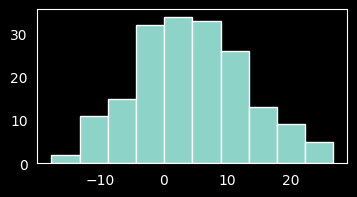

In [1845]:
plt.figure(figsize=(4, 2))
_ = plt.hist(y)

# Model

In [1846]:
K, MIN_N, SEED = 4, 6, 0
ALPHA = [0.01, 0.1, 1, 10]

In [1847]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [1848]:
pca = PCA(n_components=1, random_state=SEED).fit(X_train)
pc1_train = pca.transform(X_train).ravel()
pc1_test  = pca.transform(X_test).ravel()

# decide sign: choose orientation that gives higher corr(pc1,y)
if np.corrcoef(pc1_train, y_train)[0,1] < 0:
    pc1_train *= -1
    pc1_test  *= -1

In [1849]:
Z = np.column_stack([pc1_train, y_train])
Z = StandardScaler().fit_transform(Z)
labels = KMeans(K, random_state=SEED, n_init=20).fit(Z).labels_

In [1850]:
# keep clusters having positive slope and >= MIN_N
chosen = []
for c in np.unique(labels):
    mask = labels == c
    if mask.sum() < MIN_N:
        continue
    slope = np.polyfit(pc1_train[mask], y_train[mask], 1)[0]
    if slope > 0:
        chosen.append(c)

if not chosen: # fallback: keep everything
    chosen = np.unique(labels)

In [1851]:
def evaluate(model):
    cv = cross_val_score(model, X_train[mask], y_train[mask], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    scores = cv.mean() + cv.std()
    
    return -scores.item()

In [ ]:
mask = np.isin(labels, chosen)
model = make_pipeline(StandardScaler(), HuberRegressor(alpha=1))

evaluate(model)

0.8964289212560037

In [1853]:
model.fit(X_train[mask], y_train[mask])

HuberRegressor(alpha=0)

# Submission

In [1854]:
test_df = pd.read_csv(f"{root_path}/test.csv")
X_test = clean_df(test_df)

In [1855]:
y_pred = model.predict(X_test)

In [1856]:
submission_df = pd.DataFrame({
    "ID": test_df["ID"],
    "Target": y_pred
})

submission_df.head()

,ID,Target
0,0.0,17.226919
1,1.0,2.697050
2,2.0,-2.593337
3,3.0,4.204250
4,4.0,6.578691


In [1857]:
submission_df.to_csv("submission.csv", index=False)